In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
os.listdir('.')

['.ipynb_checkpoints',
 'longformer-base-4096-text-classification-emotion-adamw-att_win_size_128',
 'longformer-base-4096-text-classification-emotion-adamw-att_win_size_16',
 'longformer-base-4096-text-classification-emotion-adamw-att_win_size_256',
 'longformer-base-4096-text-classification-emotion-adamw-att_win_size_32',
 'longformer-base-4096-text-classification-emotion-adamw-att_win_size_64',
 'longformer-base-4096-text-classification-imdb-adamw-att_win_size_128-epochs-5',
 'longformer-base-4096-text-classification-imdb-adamw-att_win_size_128-epochs-7',
 'longformer-base-4096-text-classification-imdb-adamw-att_win_size_16-epochs-5',
 'longformer-base-4096-text-classification-imdb-adamw-att_win_size_16-epochs-7',
 'longformer-base-4096-text-classification-imdb-adamw-att_win_size_256-epochs-5',
 'longformer-base-4096-text-classification-imdb-adamw-att_win_size_256-epochs-7',
 'longformer-base-4096-text-classification-imdb-adamw-att_win_size_32-epochs-5',
 'longformer-base-4096-text-c

In [42]:
def extract_att_win_size(folder_name, contain):
    if 'roberta' in folder_name:
        return 512
    if contain == 'emotion':
        return int(folder_name.split('_')[-1])
    else:
        return int(folder_name.split('_')[-1].split('-')[0])

def plot_data(contain, metric):
    subfolders = [f.path for f in os.scandir('.') if f.is_dir() and contain in f.path]
    subfolders = sorted(subfolders, key=lambda x: extract_att_win_size(x, contain))

    if contain == 'epochs-7':
        subfolders = [x for x in subfolders if 'emotion' not in x]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for idx, subfolder in enumerate(subfolders):
        with open(os.path.join(subfolder, 'summary.json'), 'r') as f:
            summary = json.load(f)
        
        with open(os.path.join(subfolder, 'test_results.json'), 'r') as f:
            test_results = json.load(f)
        
        train_losses = pd.read_csv(os.path.join(subfolder, 'train_losses.csv'))
        val_losses = pd.read_csv(os.path.join(subfolder, 'val_losses.csv'))
        
        att_win_size = extract_att_win_size(subfolder, contain)
        
        axes[idx].plot(train_losses['epoch'], train_losses['train_' + metric], label='Train '+ metric)
        axes[idx].plot(val_losses['epoch'], val_losses['eval_' + metric], label='Validation ' + metric)

        if att_win_size == 512:
            att_win_size = 'n^2'
        main_title = f"Attention Window Size: {att_win_size}"
        subtitle = (f"Test {metric}: {test_results['test_' + metric]:.3f}, Samples/sec: {summary['samples/sec']:.2f}, "
                    f"GPU Memory: {summary['gpu_memory']} MB")
        
        axes[idx].set_title(main_title, fontsize=14, pad=20)
        axes[idx].text(0.5, 1.05, subtitle, ha='center', va='center', transform=axes[idx].transAxes, fontsize=10, alpha=0.9)
        
        if metric == 'loss':
            axes[idx].set_ylim(0,0.7)
        else:
            axes[idx].set_ylim(0.7,1)
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()
    dataset = subfolder.split('-')[5]
    fig.suptitle(f'Dataset: {dataset}', fontsize=16)

    plt.tight_layout(pad=1)
    plt.show()

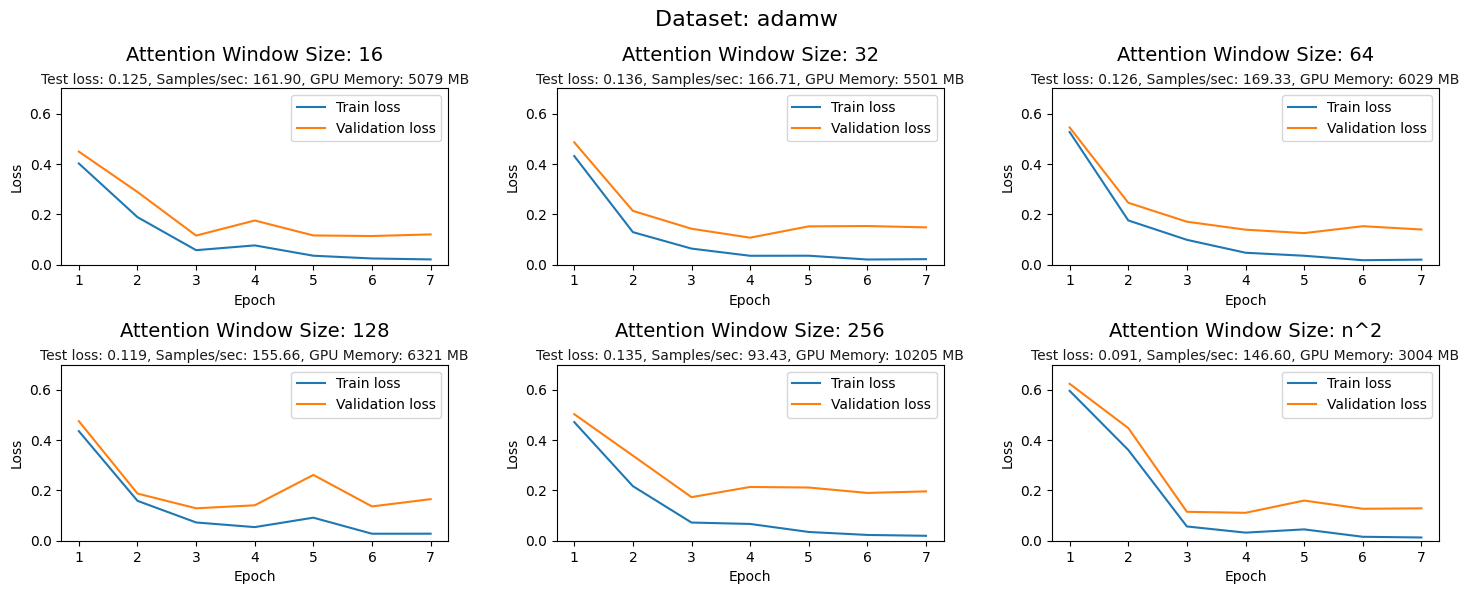

In [43]:
plot_data('emotion', 'loss')

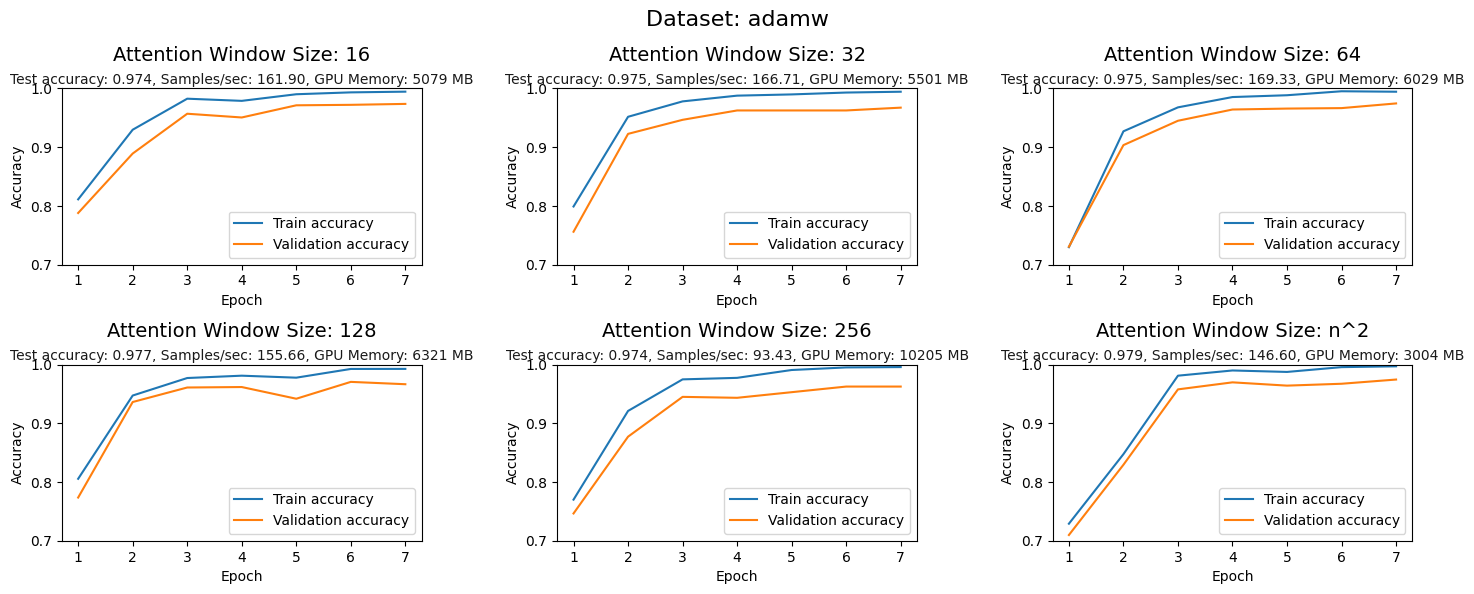

In [44]:
plot_data('emotion', 'accuracy')

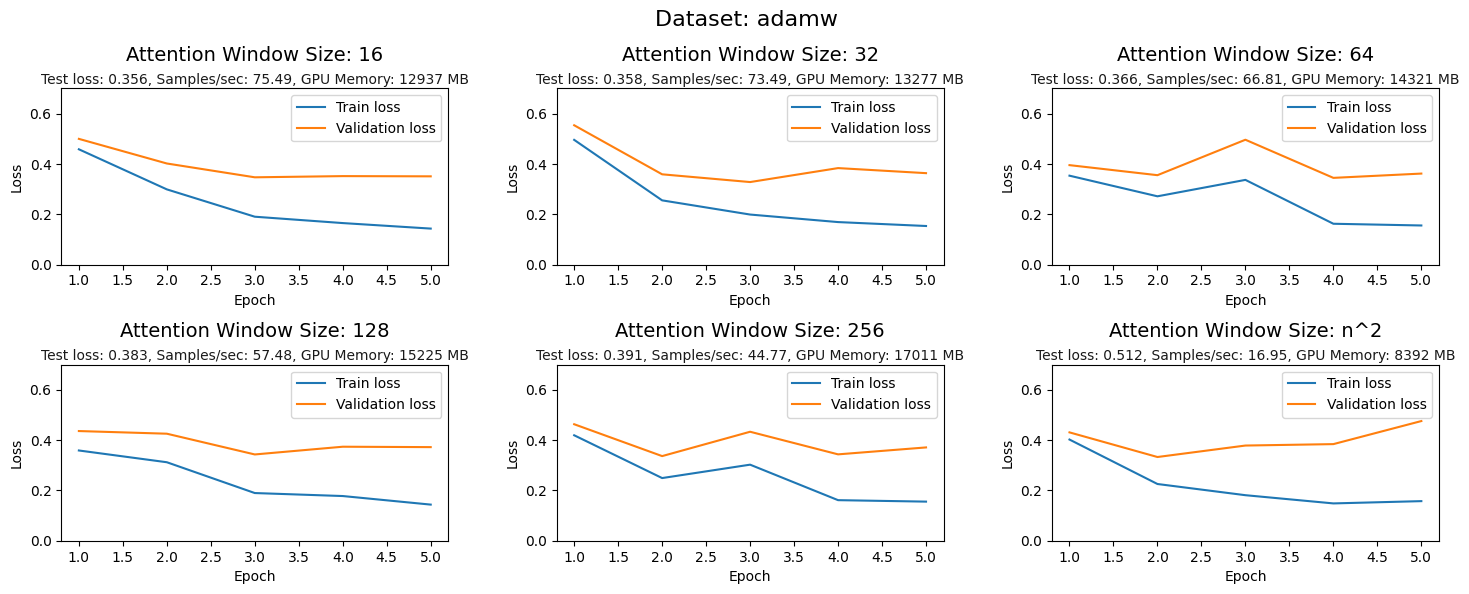

In [45]:
plot_data('epochs-5', 'loss')

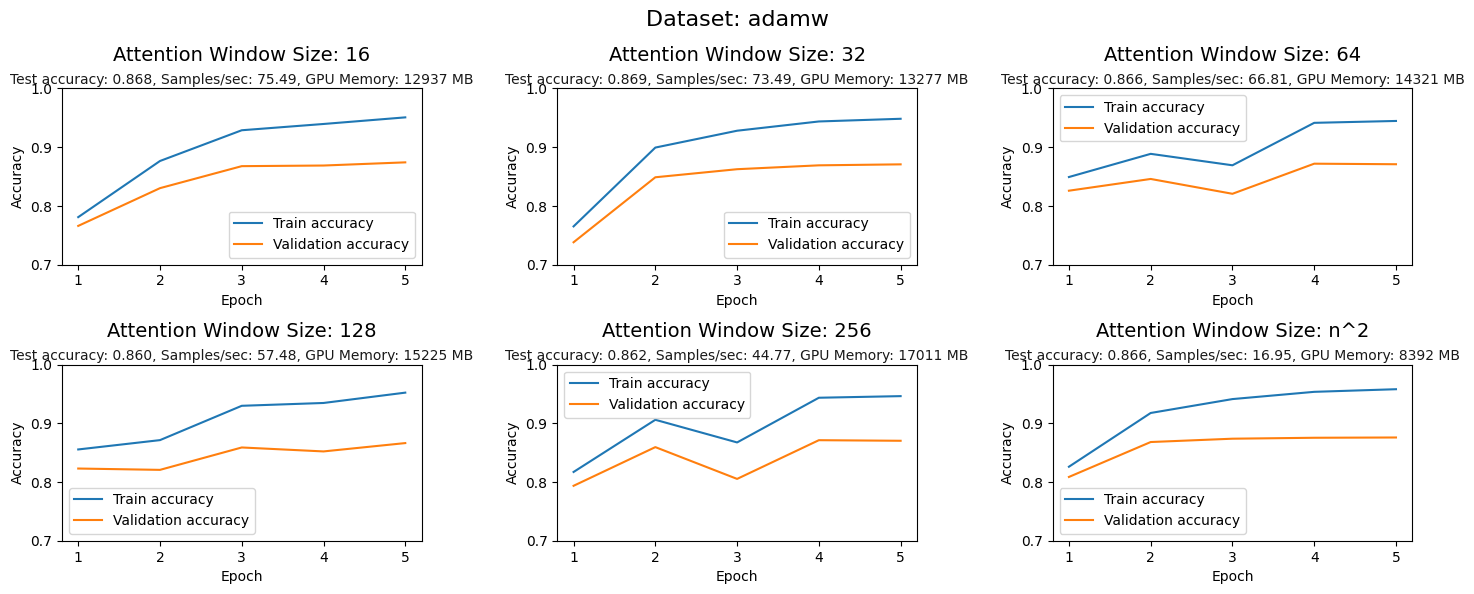

In [46]:
plot_data('epochs-5', 'accuracy')

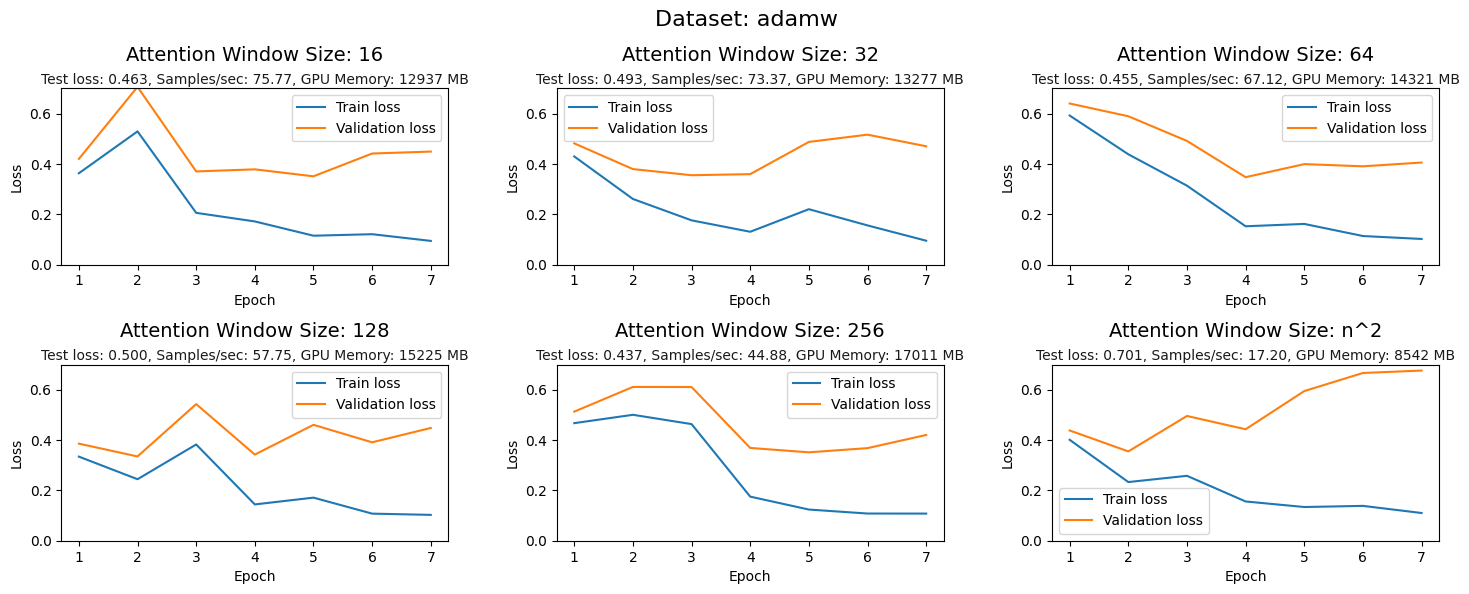

In [47]:
plot_data('epochs-7', 'loss')

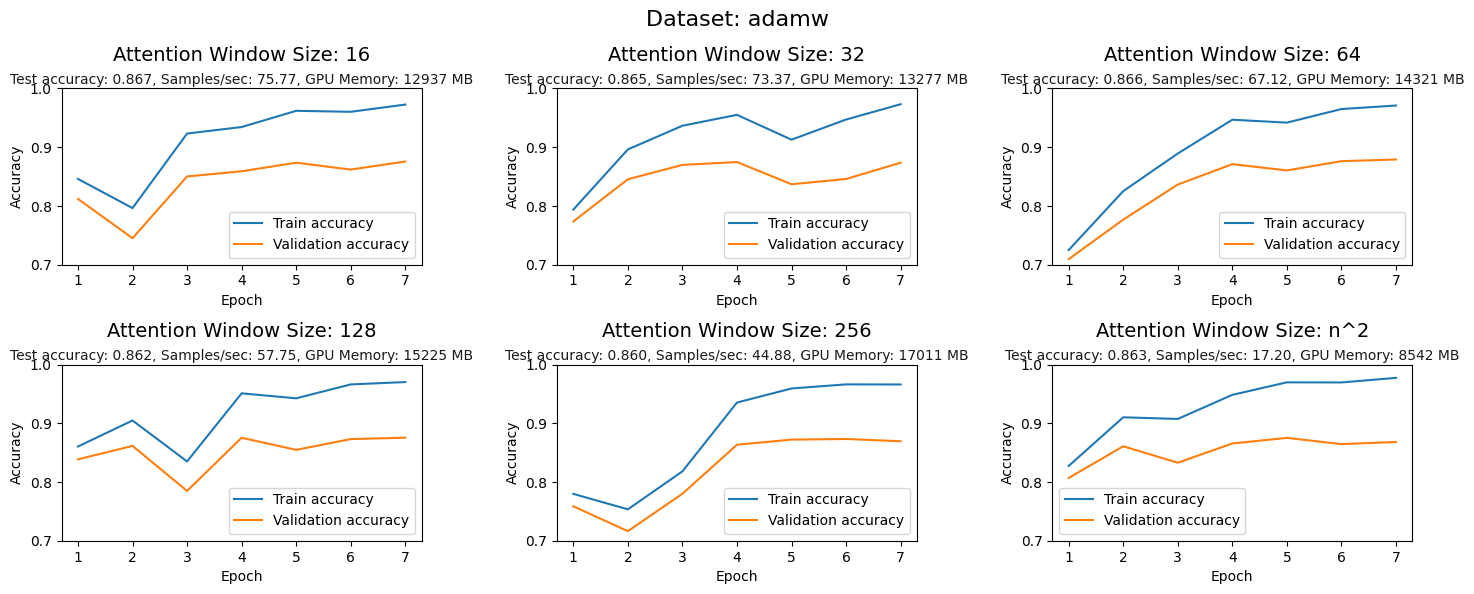

In [48]:
plot_data('epochs-7', 'accuracy')